<a href="https://colab.research.google.com/github/LiuLiuBov/EuroSATClassification/blob/main/EuroSAT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets torchvision matplotlib

# Data Acquisition

A dataset based on **Sentinel-2** satellite images covering 13 spectral bands and consisting of 10 classes with 27000 labeled and geo-referenced samples. This is the RGB version of the dataset with visible bands encoded as JPEG images.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("timm/eurosat-rgb")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/55.3M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/18.4M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/18.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16200 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5400 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 16200
    })
    validation: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 5400
    })
    test: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 5400
    })
})


**Given a satellite image of a 64×64 m area from Sentinel-2, classify the land use or land cover type among 10 predefined categories such as Forest, River, Residential, Highway, etc.**

# EDA

Lets see what are the possible labels

In [ ]:
print(dataset["train"].features)
print(dataset["train"].features['label'])
print(dataset["train"][0])

{'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']), 'image_id': Value('string')}
ClassLabel(names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'])
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7973E5C4D520>, 'label': 6, 'image_id': 'PermanentCrop_807'}


There are 10 labels:
* 'AnnualCrop'
* 'Forest'
* 'HerbaceousVegetation'
* 'Highway'
* 'Industrial'
* 'Pasture'
* 'PermanentCrop'
* 'Residential'
* 'River'
* 'SeaLake'

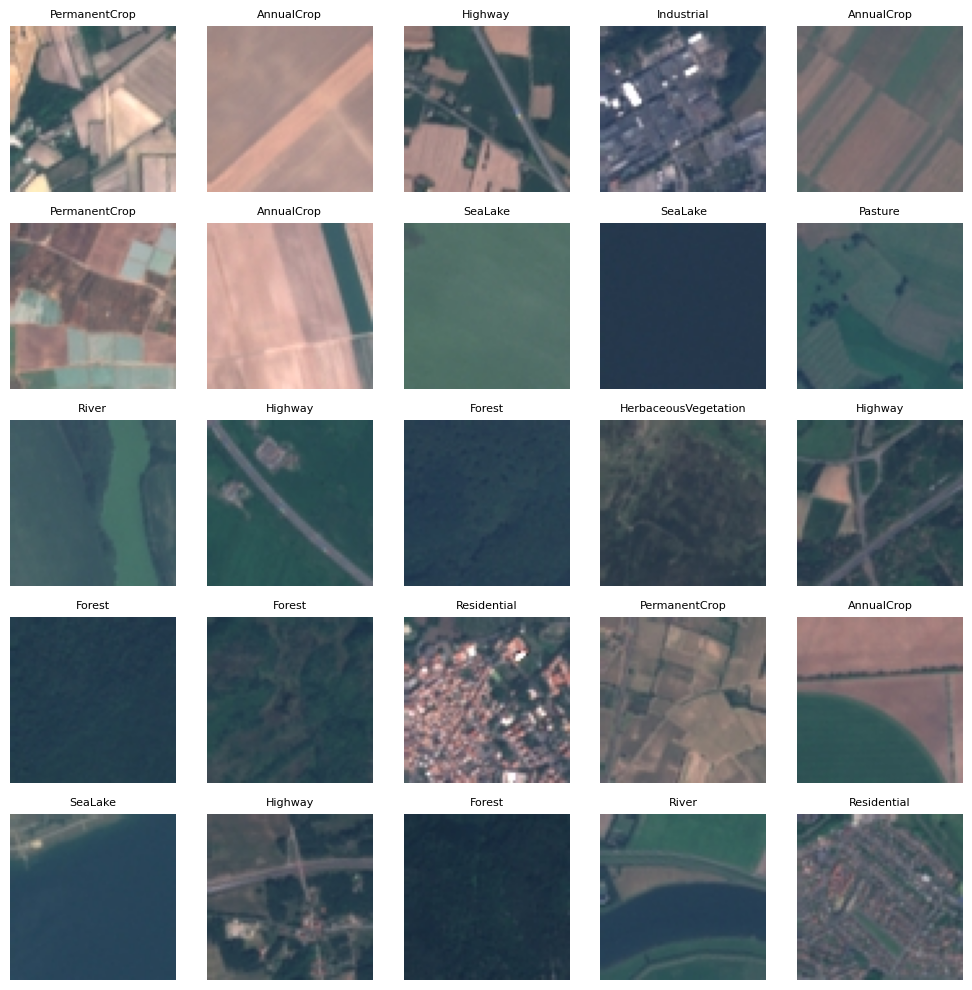

In [ ]:
import matplotlib.pyplot as plt

num_images = 25

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(num_images):
    row = i // 5
    col = i % 5
    sample = dataset["train"][i]
    img = sample["image"]
    label_id = sample["label"]
    label_name = dataset["train"].features["label"].int2str(label_id)

    axes[row, col].imshow(img)
    axes[row, col].set_title(label_name, fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


## Inspect Dataset Statistics

1. Class distribution – Are some classes over- or under-represented?
2. Image size – Are all images the same size?
3. Color channels / bands – EuroSAT RGB has 3 channels, but if we were using multispectral, we’d check all bands.

In [ ]:
import numpy as np

labels = [sample['label'] for sample in dataset['train']]

class_counts = {i: 0 for i in range(len(dataset["train"].features["label"].names))}

for label in labels:
    class_counts[label] += 1

class_counts_named = {dataset["train"].features["label"].int2str(k): v for k, v in class_counts.items()}
print("Class distribution:", class_counts_named)

img_shape = np.array([np.array(sample['image']).shape for sample in dataset['train']])
print("Image shapes (first 5):", img_shape[:5])
print("Unique shapes:", np.unique(img_shape, axis=0))

Class distribution: {'AnnualCrop': 1791, 'Forest': 1787, 'HerbaceousVegetation': 1799, 'Highway': 1505, 'Industrial': 1492, 'Pasture': 1195, 'PermanentCrop': 1481, 'Residential': 1863, 'River': 1460, 'SeaLake': 1827}
Image shapes (first 5): [[64 64  3]
 [64 64  3]
 [64 64  3]
 [64 64  3]
 [64 64  3]]
Unique shapes: [[64 64  3]]


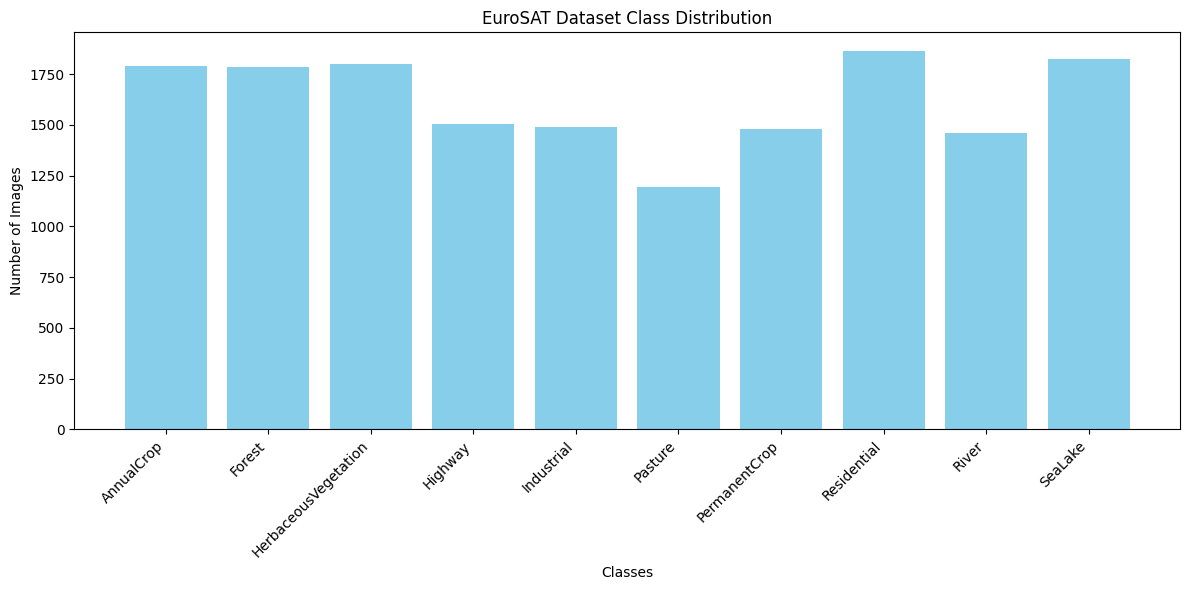

In [ ]:
classes = list(class_counts_named.keys())
counts = list(class_counts_named.values())

plt.figure(figsize=(12,6))
plt.bar(classes, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("EuroSAT Dataset Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.tight_layout()
plt.show()

## Data Preparation for Training

In [ ]:
from torchvision import transforms

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

In [ ]:
from torch.utils.data import Dataset

class EuroSATDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]
        label = self.dataset[idx]["label"]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_dataset = EuroSATDataset(
    dataset["train"],
    transform=train_transform
)

val_dataset = EuroSATDataset(
    dataset["validation"],
    transform=val_test_transform
)

test_dataset = EuroSATDataset(
    dataset["test"],
    transform=val_test_transform
)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


# Model building

Lets build a ResNet18 model adapted for EuroSAT classification. We will have transfer learning with partial fine-tuning.

## Model Architecture and Transfer Learning Strategy

In this project, a **ResNet18** convolutional neural network pretrained on the ImageNet dataset is used as the backbone for land-use and land-cover classification on the EuroSAT dataset. The model design follows a **transfer learning with partial fine-tuning** strategy, which balances performance, training efficiency, and generalization.

### Choice of ResNet18

ResNet18 is a deep convolutional neural network that uses **residual connections** to enable stable training of deeper architectures. It is computationally efficient while still powerful enough to capture complex spatial and textural patterns commonly found in satellite imagery, such as vegetation structure, urban layouts, and water bodies.

### Use of Pretrained Weights

The network is initialized with weights pretrained on the ImageNet dataset. ImageNet pretraining provides robust low-level and mid-level visual features (e.g., edges, corners, textures, and color blobs) that are largely transferable across visual domains. Leveraging these pretrained representations significantly reduces training time and improves convergence compared to training from scratch.

### Freezing Early Layers

All network parameters are initially frozen to prevent updates to early convolutional layers. These layers learn generic visual primitives that are not specific to any single domain. Freezing them:
- Reduces the number of trainable parameters
- Mitigates overfitting on a moderately sized dataset
- Stabilizes optimization during training

### Partial Fine-Tuning of High-Level Features

Only the final residual block (`layer4`) is unfrozen and fine-tuned. High-level layers capture more abstract, task-specific representations, which need adaptation to the unique spatial patterns and textures of satellite imagery. This selective fine-tuning allows the model to specialize without losing the benefits of pretrained low-level features.

### Replacement of the Classification Head

The original fully connected layer of ResNet18 is designed for 1000 ImageNet classes. It is replaced with a new fully connected layer whose output dimension matches the 10 land-cover classes of the EuroSAT dataset. This layer learns a task-specific mapping from extracted features to land-cover categories.

### Training Configuration

The model is trained on a GPU when available to accelerate computation. During optimization, only the parameters of the unfrozen layers (the final residual block and the classification head) are updated. This approach results in faster training, improved generalization, and strong performance on unseen test data.

Overall, this model design efficiently combines pretrained knowledge with task-specific adaptation, making it well-suited for satellite image classification tasks with limited labeled data.


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet18(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last residual block
for param in model.layer4.parameters():
    param.requires_grad = True

# Replace final classification layer
num_classes = len(dataset['train'].features['label'].names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Ensure classifier is trainable
for param in model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Define Loss and Optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])

Cross-entropy loss is used for multi-class classification.

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.3,
    patience=2
)

# Model training loop

In [ ]:
def calculate_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


In [ ]:
from google.colab import drive
drive.mount('/content/my_drive')

Mounted at /content/my_drive


In [ ]:
import os

os.makedirs("/content/my_drive/MyDrive/EuroSAT_models", exist_ok=True)

In [ ]:
import copy

num_epochs = 30
patience = 5
best_val_acc = 0.0
counter = 0

best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() # Gradients accumulate by default in PyTorch. This step clears gradients from the previous iteration.
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    val_acc = calculate_accuracy(val_loader, model, device)

    scheduler.step(val_acc)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {epoch_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

    drive_path = "/content/my_drive/MyDrive/EuroSAT_models/best_resnet18_eurosat.pth"

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), drive_path)
        counter = 0
        print("✓ Best model saved")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        break

model.load_state_dict(best_model_wts)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/30] | Train Loss: 1.0357 | Val Acc: 0.8700
✓ Best model saved
Epoch [2/30] | Train Loss: 0.8672 | Val Acc: 0.9035
✓ Best model saved
Epoch [3/30] | Train Loss: 0.8114 | Val Acc: 0.8983
Epoch [4/30] | Train Loss: 0.7899 | Val Acc: 0.9217
✓ Best model saved
Epoch [5/30] | Train Loss: 0.7738 | Val Acc: 0.8728
Epoch [6/30] | Train Loss: 0.7572 | Val Acc: 0.9265
✓ Best model saved
Epoch [7/30] | Train Loss: 0.7496 | Val Acc: 0.9228
Epoch [8/30] | Train Loss: 0.7327 | Val Acc: 0.9083
Epoch [9/30] | Train Loss: 0.7259 | Val Acc: 0.9385
✓ Best model saved
Epoch [10/30] | Train Loss: 0.7229 | Val Acc: 0.9346
Epoch [11/30] | Train Loss: 0.7141 | Val Acc: 0.9396
✓ Best model saved
Epoch [12/30] | Train Loss: 0.7067 | Val Acc: 0.9456
✓ Best model saved
Epoch [13/30] | Train Loss: 0.7001 | Val Acc: 0.9376
Epoch [14/30] | Train Loss: 0.6901 | Val Acc: 0.9344
Epoch [15/30] | Train Loss: 0.6874 | Val Acc: 0.9446
Epoch [16/30] | Train Loss: 0.6544 | Val Acc: 0.9459
✓ Best model saved
Epoch [17

<All keys matched successfully>

#Test Set Evaluation & Confusion Matrix

In [ ]:
model.load_state_dict(torch.load("/content/my_drive/MyDrive/EuroSAT_models/best_resnet18_eurosat.pth"))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def test_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

test_acc = test_accuracy(test_loader, model, device)
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Accuracy: 0.9537


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


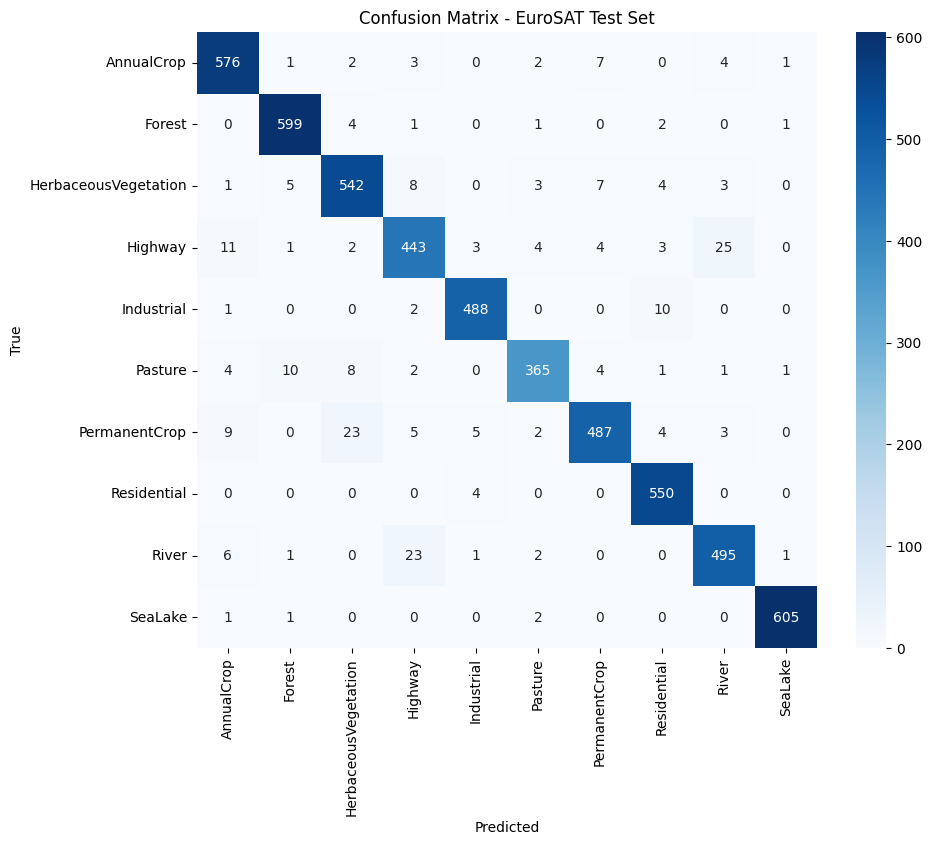

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
classes = dataset['train'].features['label'].names

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - EuroSAT Test Set")
plt.show()

## Conclusion

In this project, a ResNet18 model with transfer learning and partial fine-tuning was applied to the EuroSAT RGB dataset for land-use and land-cover classification. Through data augmentation, careful model freezing/unfreezing, and validation-driven training strategies, the model achieved a **test accuracy of 95.37%**. The results demonstrate that pretrained convolutional neural networks can effectively capture spatial patterns in satellite imagery and generalize well to unseen data, even with relatively small image resolutions.
